In [47]:
import sympy as smp
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from visualization import Animator, AnimatableKSegmentData, AnimatableLinePlot
from math import *

In [2]:
L, m, t, g = smp.symbols('L m t g')
theta1, theta2 = smp.Function("theta1")(t), smp.Function("theta2")(t) 

dtheta1, dtheta2 = smp.diff(theta1, t), smp.diff(theta2, t)
ddtheta1, ddtheta2 = smp.diff(dtheta1, t), smp.diff(dtheta2, t)

p1 = np.array([
    L * smp.cos(theta1),
    L * smp.sin(theta1)])

p2 = p1 + np.array([
    L * smp.cos(theta1 + theta2),
    L * smp.sin(theta1 + theta2)
])

v1 = np.array([
    smp.diff(p1[0], t),
    smp.diff(p1[1], t)
])

v2 = np.array([
    smp.diff(p2[0], t),
    smp.diff(p2[1], t)
])

K = m * ((v1**2).sum() + (v2**2).sum()) / 2
P = m *g * (p1[1] + p2[1])

Lagrangian = K - P

In [3]:
tau1 = smp.diff(
    smp.diff(Lagrangian, dtheta1),t
) - smp.diff(Lagrangian, theta1)

tau2 = smp.diff(
    smp.diff(Lagrangian, dtheta2),t
) - smp.diff(Lagrangian, theta2)

In [4]:
_theta1 = smp.symbols('theta1')
_theta2 = smp.symbols('theta2')
_dtheta1 = smp.symbols('dtheta1')
_dtheta2 = smp.symbols('dtheta2')
_ddtheta1 = smp.symbols('ddtheta1')
_ddtheta2 = smp.symbols('ddtheta2')

tau1 = tau1.subs({ddtheta1: _ddtheta1, ddtheta2: _ddtheta2}).subs({dtheta1: _dtheta1, dtheta2: _dtheta2}).subs({theta1: _theta1, theta2: _theta2})
tau2 = tau2.subs({ddtheta1: _ddtheta1, ddtheta2: _ddtheta2}).subs({dtheta1: _dtheta1, dtheta2: _dtheta2}).subs({theta1: _theta1, theta2: _theta2})

In [5]:
params = {
    g: 9.8,
    m: 1,
    L: 0.3
}

my_tau1 = smp.symbols('tau1')
my_tau2 = smp.symbols('tau2')

forward_dynamics = smp.solve([tau1.subs(params) - my_tau1, tau2.subs(params) - my_tau2],
                             [_ddtheta1, _ddtheta2])
forward_dynamics = {theta: exp.simplify() for theta, exp in forward_dynamics.items()}

inverse_dynamics = smp.solve([tau1.subs(params) - my_tau1, tau2.subs(params) - my_tau2],
                             [my_tau1, my_tau2])
inverse_dynamics = {theta: exp.simplify() for theta, exp in inverse_dynamics.items()}

In [6]:
print(inverse_dynamics[my_tau2].simplify())

0.09*ddtheta1*cos(theta2) + 0.09*ddtheta1 + 0.09*ddtheta2 + 0.09*dtheta1**2*sin(theta2) + 2.94*cos(theta1 + theta2)


In [84]:
# q : theta1, theta2
X = np.array([0.0, 1.0, 3.0, 1.0], dtype=np.float64) # state: q, dq
X_goal = np.array([-np.pi * 0.75, -np.pi * 0.5, 0, 0])

# copied from forward_dynamics[_ddtheta1]
def forw_dynamics_theta1(theta1, theta2, dtheta1, dtheta2, tau1, tau2):
    return 1.5*(1.33333333333333*dtheta1**2*sin(theta2) + 0.666666666666666*dtheta1**2*sin(2*theta2) + 2.66666666666667*dtheta1*dtheta2*sin(theta2) + 1.33333333333333*dtheta2**2*sin(theta2) + 14.8148148148148*tau1 - 14.8148148148148*tau2*cos(theta2) - 14.8148148148148*tau2 - 65.3333333333333*cos(theta1) + 21.7777777777778*cos(theta1 + 2*theta2))/(3 - cos(2*theta2))


# copied from forward_dynamics[_ddtheta2]
def forw_dynamics_theta2(theta1, theta2, dtheta1, dtheta2, tau1, tau2):
    return 1.5*(-2.0*dtheta1**2*sin(theta2) - 0.666666666666667*dtheta1**2*sin(2*theta2) - 1.33333333333333*dtheta1*dtheta2*sin(theta2) - 0.666666666666667*dtheta1*dtheta2*sin(2*theta2) - 0.666666666666667*dtheta2**2*sin(theta2) - 0.333333333333333*dtheta2**2*sin(2*theta2) - 7.40740740740741*tau1*cos(theta2) - 7.40740740740741*tau1 + 14.8148148148148*tau2*cos(theta2) + 22.2222222222222*tau2 + 32.6666666666667*cos(theta1) + 21.7777777777778*cos(theta1 - theta2) - 21.7777777777778*cos(theta1 + theta2) - 10.8888888888889*cos(theta1 + 2*theta2))/(sin(theta2)**2 + 1)

# copied from inverse_dynamics[my_tau1]
def inverse_dynamics_theta1(theta1, theta2, dtheta1, dtheta2, ddtheta1, ddtheta2):
    return 0.18*ddtheta1*cos(theta2) + 0.27*ddtheta1 + 0.09*ddtheta2*cos(theta2) + 0.09*ddtheta2 - 0.18*dtheta1*dtheta2*sin(theta2) - 0.09*dtheta2**2*sin(theta2) + 5.88*cos(theta1) + 2.94*cos(theta1 + theta2)

# copied from inverse_dynamics[my_tau2]
def inverse_dynamics_theta2(theta1, theta2, dtheta1, dtheta2, ddtheta1, ddtheta2):
    return 0.09*ddtheta1*cos(theta2) + 0.09*ddtheta1 + 0.09*ddtheta2 + 0.09*dtheta1**2*sin(theta2) + 2.94*cos(theta1 + theta2)


def dstate_dt(t, X, tau):
    return np.array([
            *X[2:],
            forw_dynamics_theta1(theta1=X[0], theta2=X[1], dtheta1=X[2], dtheta2=X[3], tau1=tau[0], tau2=tau[1]),
            forw_dynamics_theta2(theta1=X[0], theta2=X[1], dtheta1=X[2], dtheta2=X[3], tau1=tau[0], tau2=tau[1])
    ])

# def inverse_kinematics(end_effector, d_end_effector):
#     res = smp.solve([
#             *(p2 - end_effector),
#             *(v2 - d_end_effector)
#     ])
#     return np.array([ # there might be degeneracy here...
#         float(res[theta1]), float(res[theta1]),
#         float(res[dtheta1]), float(res[dtheta2])
#     ])

dt = 0.001
cur_t = 0
T = 4

def controller(t, X):
    q_init = X[0:2]
    dq_init = X[2:4]
    q_goal = X_goal[0:2]
    dq_goal = X_goal[2:4]
    T_rem = T - t + 1e-9 # epsillon
    
    # set up interpolation parameters
    # q_goal - q_init = integrate_T   dq
    # dq_expression = dq_goal * t / T + dq_init * (T - t) / T + t * (T - t) * helper
    # integrate the above
    # q_goal - q_init = (dq_init + dq_goal) * T / 2 + (T^3/6) * helper
    # helper = (q_goal - q_init - (dq_init + dq_goal) * T_rem / 2) / (T_rem * T_rem * T_rem / 6)
    
    # ddq = derivative of dq_expression
    ddq = dq_goal / T_rem - dq_init / T_rem + (q_goal - q_init - (dq_init + dq_goal) * T_rem / 2) / (T_rem * T_rem) * 6
    return np.array([
      inverse_dynamics_theta1(theta1=X[0], theta2=X[1], dtheta1=X[2], dtheta2=X[3], ddtheta1=ddq[0], ddtheta2=ddq[1]),
      inverse_dynamics_theta2(theta1=X[0], theta2=X[1], dtheta1=X[2], dtheta2=X[3], ddtheta1=ddq[0], ddtheta2=ddq[1])                      
    ])


points = []
ts = []

p1_str = [str(elem) for elem in p1]
p2_str = [str(elem) for elem in p2]

while cur_t < T:
    theta1 = X[0]
    theta2 = X[1]
    p1 = params[L] * np.array([np.cos(theta1), np.sin(theta1)])
    p2 = p1 + params[L] * np.array([np.cos(theta1 + theta2), np.sin(theta1 + theta2)])
    tau = controller(cur_t, X)
    points.append([
        [0, 0],
        p1, p2
    ])
    ts.append(cur_t)
    cur_t += dt
    X = integrate.odeint(lambda t, X: dstate_dt(t, X, tau), X, [0, dt], tfirst=True)[1]


/home/shayan/.local/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


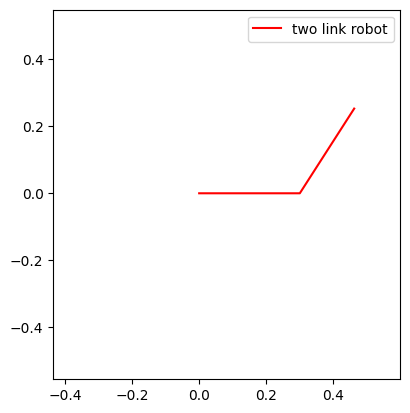

In [85]:
fig, main_ax = plt.subplots(1, 1)

segments = AnimatableKSegmentData(main_ax, points_data=points, name="two link robot", fix_scale=True)
animator = Animator(fig=fig, interval=30, total_time=T, animatable_datas=[segments], speed=1)

anim = FuncAnimation(animator.fig,
                     animator.animate,
                     frames=animator.num_frames,
                     interval=animator.interval)

from IPython.display import HTML

HTML(anim.to_jshtml())